In [41]:
# setting environment
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [42]:
# read in data
airline2008 = pd.read_csv('data/2008.csv')

In [43]:
# examine the size of dataset
airline2008.shape

(7009728, 29)

In [44]:
# check the first few rows to see what it looks like
airline2008.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [45]:
# check the info of each column
airline2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [46]:
# check the related column
airline2008[['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
            'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut']].head(10)

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,TaxiIn,TaxiOut
0,2003.0,1955,2211.0,2225,128.0,150.0,116.0,-14.0,8.0,4.0,8.0
1,754.0,735,1002.0,1000,128.0,145.0,113.0,2.0,19.0,5.0,10.0
2,628.0,620,804.0,750,96.0,90.0,76.0,14.0,8.0,3.0,17.0
3,926.0,930,1054.0,1100,88.0,90.0,78.0,-6.0,-4.0,3.0,7.0
4,1829.0,1755,1959.0,1925,90.0,90.0,77.0,34.0,34.0,3.0,10.0
5,1940.0,1915,2121.0,2110,101.0,115.0,87.0,11.0,25.0,4.0,10.0
6,1937.0,1830,2037.0,1940,240.0,250.0,230.0,57.0,67.0,3.0,7.0
7,1039.0,1040,1132.0,1150,233.0,250.0,219.0,-18.0,-1.0,7.0,7.0
8,617.0,615,652.0,650,95.0,95.0,70.0,2.0,2.0,6.0,19.0
9,1620.0,1620,1639.0,1655,79.0,95.0,70.0,-16.0,0.0,3.0,6.0


The goal of this project is to predict how late flights will be, thus `ArrDelay` column will be our outcome variable, one thing to be aware of is the leaking information that might be in the dataset, for example, we could easily calculate the answer by substracting scheduled arrival time `CRSArrTime` from actual arrival time `ArrTime`. We should only use the columns that was known when the flight has not actually taken off yet, for instance, we need to drop `DepTime`, `ActualElapsedTime`, `ArrTime`, those are "future" information that we would not have known.

In [47]:
# check the null values in the dataset
airline2008.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

Obviously we have some data cleaning to do before jumping into the problem, we are only interested in predicting the late flight, flight is only considered "late" if the actual arrival time is 30 minutes more than the scheduled, thus we only need to keep the flights that are late as our training set, we can eliminate the cancelled flights as well since this is not going to provide much information, let's keep the flights that have value 0 in `Cancelled` column to see if we clean out most of the null.

In [48]:
# keep data with cancelled column equals 0
airline2008_clean = airline2008[airline2008['Cancelled']==0]
airline2008_clean.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                14215
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    7
ActualElapsedTime      17265
CRSElapsedTime           598
AirTime                17265
ArrDelay               17265
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                 14215
TaxiOut                    0
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5347559
WeatherDelay         5347559
NASDelay             5347559
SecurityDelay        5347559
LateAircraftDelay    5347559
dtype: int64

We definitely clean out a lot of rows here, our next step is to keep only the flights that are late(`ArrDelay` > 30)

In [49]:
# keep only the late flights
airline2008_clean = airline2008_clean[airline2008_clean['ArrDelay'] > 30]
airline2008_clean.isnull().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                   0
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   2
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
Cancelled                 0
CancellationCode     901398
Diverted                  0
CarrierDelay              0
WeatherDelay              0
NASDelay                  0
SecurityDelay             0
LateAircraftDelay         0
dtype: int64

In [50]:
# drop cancellationcode since it does not make sense if the flight is not cancelled
airline2008_clean.drop(['CancellationCode'], axis=1, inplace=True)

In [51]:
# check the cleaned dataset size
airline2008_clean.shape

(901398, 28)

We reduce our data size from around 7 million into 900K, which should definitely accelerate the model fitting, our next step is to drop the columns that have leaking information

In [52]:
col_drop = ['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 'DepDelay', 'TaxiIn', 'TaxiOut',
           'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
airline2008_clean.drop(col_drop, axis=1, inplace=True)

In [53]:
airline2008_clean.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,ArrDelay,Origin,Dest,Distance,Cancelled,Diverted
4,2008,1,3,4,1755,1925,WN,3920,N464WN,90.0,34.0,IND,BWI,515,0,0
6,2008,1,3,4,1830,1940,WN,509,N763SW,250.0,57.0,IND,LAS,1591,0,0
11,2008,1,3,4,1510,1725,WN,1333,N334SW,135.0,80.0,IND,MCO,828,0,0
19,2008,1,3,4,1325,1435,WN,54,N643SW,70.0,37.0,ISP,BWI,220,0,0
26,2008,1,3,4,1255,1610,WN,188,N215WN,195.0,47.0,ISP,FLL,1093,0,0


In [54]:
# check the number of unique values in each column and decide whether we should drop the columns or not
airline2008_clean.nunique()

Year                 1
Month               12
DayofMonth          31
DayOfWeek            7
CRSDepTime        1174
CRSArrTime        1347
UniqueCarrier       20
FlightNum         7464
TailNum           5341
CRSElapsedTime     498
ArrDelay          1028
Origin             301
Dest               301
Distance          1401
Cancelled            1
Diverted             1
dtype: int64

Since `Year`, `Cancelled` and `Diverted` column has only one unique value, it does not provide any information for our prediction purpose, we will drop those

In [55]:
# drop more columns
airline2008_clean.drop(['Year', 'Cancelled', 'Diverted'], axis=1, inplace=True)

In [56]:
airline2008_clean.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

After some data cleaning, our next step is to examine the features and do some feature engineering and selection

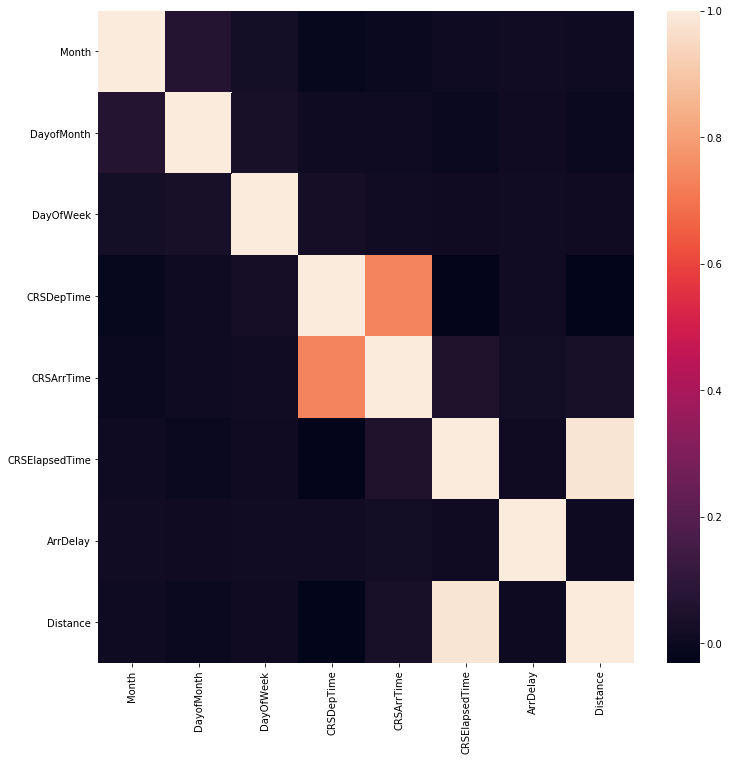

In [57]:
# check the correlation of each column
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax = sns.heatmap(airline2008_clean.corr())

We can see there are many time-associated columns, we will deal with them to extract some useful information first, we first deal with CRSDepTime and CRSArrTime, since these two columns represent time but they actually use the number, we will extract the "hour" information only since the minutes are too detail it probably will not help much with our model, on the other hand, hour has information like midnight, morning, noon, afternoon...etc. and might be somehow related how much the flight will delay

In [58]:
# create a function that extracts the hour information
def extract_hour(col):
    col = str(col)
    if len(col) in [1,2]:
        return 0
    elif len(col) == 3:
        return int(col[0])
    else:
        return int(col[:2])            

In [59]:
airline2008_clean['Dep_hour'] = airline2008_clean['CRSDepTime'].apply(extract_hour)
airline2008_clean['Arr_hour'] = airline2008_clean['CRSArrTime'].apply(extract_hour)

In [60]:
# check the result
airline2008_clean.sample(5)

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,ArrDelay,Origin,Dest,Distance,Dep_hour,Arr_hour
2847551,5,4,7,805,913,9E,68.0,50.0,FWA,DTW,128,8,9
3540948,6,6,5,1155,1448,B6,173.0,88.0,SYR,FLL,1197,11,14
3319841,6,25,3,1740,1844,EV,64.0,61.0,TLH,MCO,227,17,18
524059,1,31,4,1515,1840,AA,145.0,98.0,MIA,SJU,1045,15,18
4171600,7,14,1,1855,2148,B6,173.0,63.0,PBI,LGA,1035,18,21


Next we will deal with `DayOfWeek` column, we will create a binary column `Weekend` to check whether the amount of delay is different between weekend and weekday flights

In [61]:
# create weekend column
airline2008_clean['Weekend'] = np.where(airline2008_clean['DayOfWeek'] > 5, 1, 0)

In [62]:
airline2008_clean['Weekend'].value_counts()

0    669366
1    232032
Name: Weekend, dtype: int64

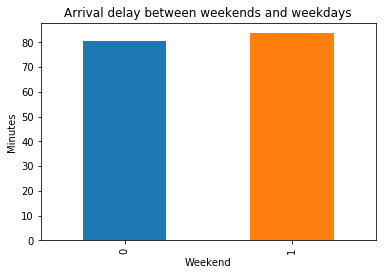

In [63]:
# plot the amount of delay between weekdays and weekends flight
ax = airline2008_clean.groupby('Weekend')['ArrDelay'].mean().plot(kind='bar')
ax.set_title('Arrival delay between weekends and weekdays')
ax.set_ylabel('Minutes')
plt.show()

Looks like flights on weekends seem to delay more than on weekdays. Our next step is to deal with the categorical variables: `UniqueCarrier`, `Origin`, `Dest`, since they are purely nominal and does not have any particular order, we will use the pd.get_dummies function directly. One thing to note is `Month`, `DayofMonth` and `DayofWeek` columns, they should be categorical as well since the number should not have order in this case.

In [64]:
# convert three columns to object type
airline2008_clean[['Month', 'DayofMonth', 'DayOfWeek']] = airline2008_clean[['Month', 'DayofMonth', 
                                                                             'DayOfWeek']].astype('str')
airline2008_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901398 entries, 4 to 7009718
Data columns (total 14 columns):
Month             901398 non-null object
DayofMonth        901398 non-null object
DayOfWeek         901398 non-null object
CRSDepTime        901398 non-null int64
CRSArrTime        901398 non-null int64
UniqueCarrier     901398 non-null object
CRSElapsedTime    901398 non-null float64
ArrDelay          901398 non-null float64
Origin            901398 non-null object
Dest              901398 non-null object
Distance          901398 non-null int64
Dep_hour          901398 non-null int64
Arr_hour          901398 non-null int64
Weekend           901398 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 103.2+ MB


In [65]:
# deal with dummy variables
airline2008_clean = pd.get_dummies(airline2008_clean)

In [66]:
# drop the original data we use to create other features
airline2008_clean.drop(['CRSDepTime', 'CRSArrTime'], axis=1, inplace=True)

Now we are ready to fit our model, we first create a function that determines the performance of a particular model

In [67]:
from sklearn.model_selection import GridSearchCV
def get_best_model(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0., cv=3, scoring='neg_mean_squared_error')
    grid.fit(X, y)
    # our classical metric for performance
    print("Best Accuracy: {}".format(grid.best_score_))
    # the best parameters that caused the best accuracy
    print("Best Parameters: {}".format(grid.best_params_))
    # the average time it took a model to fit to the data (in seconds)
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
    

In [68]:
# split our model into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(airline2008_clean.drop(['ArrDelay'], axis=1),
                                                airline2008_clean['ArrDelay'], test_size=0.3, random_state=1009)

### Linear regression

In [69]:
X_train.nunique().sort_values(ascending=False).head()

Distance          1395
CRSElapsedTime     493
Dep_hour            24
Arr_hour            24
Origin_JAN           2
dtype: int64

In [30]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# set up hyperparameters
lr_params = {'fit_intercept': [True, False]}
get_best_model(lr, lr_params, X_train, y_train)

Best Accuracy: -4819855.645325443
Best Parameters: {'fit_intercept': True}
Average Time to Fit (s): 26.316
Average Time to Score (s): 0.963


### Ridge regression

In [31]:
from sklearn.linear_model import Ridge
rg = Ridge()
# set up hyperparameters
rg_params = {'alpha':[0.1,1,10,100]}
get_best_model(rg, rg_params, X_train, y_train)

Best Accuracy: -3973.657729411533
Best Parameters: {'alpha': 100}
Average Time to Fit (s): 8.145
Average Time to Score (s): 0.929


### Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
la = Lasso()
# set up hyperparameters
la_params = {'alpha':[0.001,0.01,0.1,1,10,100]}
get_best_model(la, la_params, X_train, y_train)

### Decision tree

In [71]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
# set up hyperparameters
tree_params = {'max_depth':[3,5,7]}
get_best_model(tree, tree_params, X_train, y_train)

Best Accuracy: -3940.0307703813196
Best Parameters: {'max_depth': 7}
Average Time to Fit (s): 11.995
Average Time to Score (s): 1.317


### Support vector machine

In [72]:
from sklearn.svm import LinearSVR
svr = LinearSVR()
# set up hyperparameters
svr_params = {'C': [0.1,1,10,100]}
get_best_model(svr, svr_params, X_train, y_train)

Best Accuracy: -4843.271397966354
Best Parameters: {'C': 0.1}
Average Time to Fit (s): 147.785
Average Time to Score (s): 1.054


In [73]:
# use decision tree model to test the test set
from sklearn.metrics import mean_squared_error
tree = DecisionTreeRegressor(max_depth=7)
tree.fit(X_train, y_train)
print('Performance: {}'.format(mean_squared_error(y_test, tree.predict(X_test))))

Performance: 3883.0650024928154
